# Infering the Mass-Luminosity Relation with Physical Components and Weak Lensing

*David Thomas 2017/01/10*

In [77]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## 1. Introduction

Modern numerical simulations have given us a good understanding of dark matter structure for standard cosmological scenarios, while surveys have done the same for the distribution of galaxies. This has allowed us to develop a good picture of how mass and luminosity are distributed in the universe. While analytic functions capturing the relationship between mass and luminosity exist, exploring alternative analytic forms is an area of active research [1]. Another active area of research is mapping the mass structure of the universe. Better resolution on dark matter halo masses, the dominant contributor to the universe mass structure (84%), allows us to further constrain cosmology and theories of galaxy formation and evolution. We would like to combine both these areas in a new joint analysis. We propose building a hierarchical inference that will explore the mass luminosity relation and simultaneously map the mass structure of the universe. The benefits of this approach are not only the dual results, but also that combining them in a self consistent manner will allow us to harness more information in the data and achieve better constraints. 

The core parameters in our model are associated with two groups of galaxies: foreground and background galaxies. Foreground galaxies have halos whose mass we will infer and background galaxies lie behind them and provide weak lensing information to guide the inference. Each foreground galaxy $i$ has a halo mass $M_h^i$, concentration $c^i$, intrinsic luminosity $L^i$, and observed luminosity $L^i_{obs}$. Each background galaxy $j$ has a shear $g^j$, intrinsic ellipticity $\epsilon^j$, and observed ellipticity $\epsilon^j_{obs}$. Both foreground and background galaxies also have a redshift $z$ and angular location $x$. Beyond these core parameters, there are also hyperparameters. $\sigma_{\epsilon}^{int}$ and $\sigma_{\epsilon}^{obs}$ represent the intrinsic and observed ellipticity dispersion. Similarly, $\sigma_L$ represents the observed ellipticity dispersion. $\beta$ captures our assumptions about the form of the concentration and $\Omega$ represents the cosmological parameters we assume for the mass distribution. Finally, we have hyperparameter distributions $\alpha$ and $S$ for the analytic parameters and scatter of the mass luminosity relation. These are the two hyperparameters we focus on learning. Below is a probabilistic graphical model (PGM) presenting the variables explained above and showing their relationships.

In order to utilize the weak lensing of the background galaxies to inform the mass distribution we will need to use a field of view that is typical for weak lensing analysis. We will be using a 40 arcmin x 40 arcmin angular view with galaxies out to redshift 3.2. This choice is significant because it means that we should expect around 100,000 galaxies in our foreground. Thus we will be operating in an extremely high dimensional space and both computational and statistical reductions will need to be explored to make this model tractable.

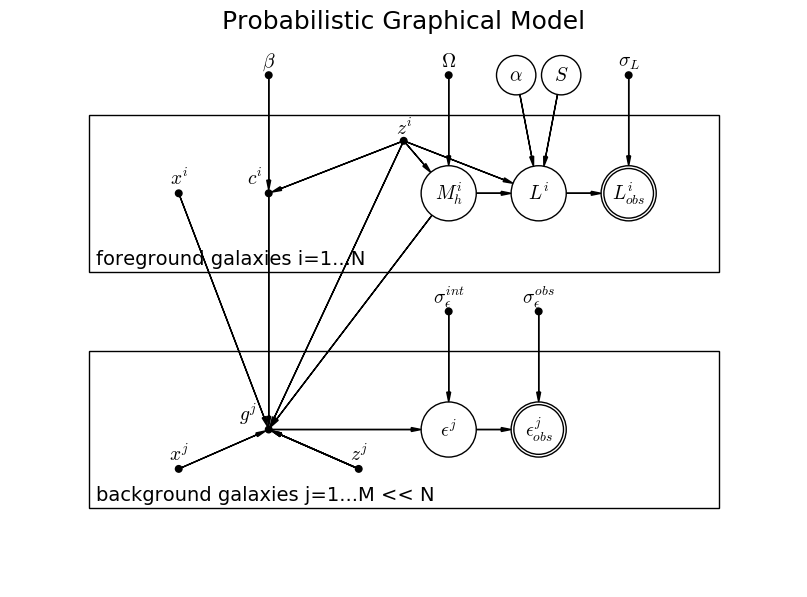

In [12]:
%matplotlib inline

from daft import PGM, Plate, Node
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['font.size'] = 14

#dimensions
pgm_height = 7.
pgm_width = 10.
border = 1.0
scale = 1.4
smallscale=1.0
plate_width = pgm_width - 2. * border
plate_height = (pgm_height - 3. * border) / 2.
plate_1_x = border
plate_1_y = border
plate_2_x = border
plate_2_y = plate_height + 2. * border
plate_1_mid = plate_height / 2. + plate_1_y
plate_2_mid = plate_height / 2. + plate_2_y
seventh = plate_width / 7.

pgm = PGM([pgm_width, pgm_height], origin=[0, 0], observed_style="inner")

#plate
pgm.add_plate(Plate([plate_1_x, plate_1_y, plate_width, plate_height], label="background galaxies j=1...M << N"))
pgm.add_plate(Plate([plate_2_x, plate_2_y, plate_width, plate_height], label="foreground galaxies i=1...N"))

#nodes
pgm.add_node(Node('x_j', '$x^j$', plate_1_x + seventh, plate_1_mid-border/2., fixed=True))
pgm.add_node(Node('g_j', '$g^j$', plate_1_x + 2. * seventh, plate_1_mid, fixed=True, offset=(-15,0)))
pgm.add_node(Node('z_j', '$z^j$', plate_1_x + 3. * seventh, plate_1_mid-border/2., fixed=True))
pgm.add_node(Node('e_j', '$\epsilon^j$', plate_1_x + 4. * seventh, plate_1_mid, scale=scale))
pgm.add_node(Node('e_obs_j', '$\epsilon_{obs}^j$', plate_1_x + 5. * seventh, plate_1_mid, scale=scale, observed=True))

pgm.add_node(Node('x_i', '$x^i$', plate_2_x + seventh, plate_2_mid, fixed=True))
pgm.add_node(Node('c_i', '$c^i$', plate_2_x + 2. * seventh, plate_2_mid, fixed=True, offset=(-10,0)))
pgm.add_node(Node('z_i', '$z^i$', plate_2_x + 3.5 * seventh, plate_2_mid + plate_height / 3, fixed=True, offset=(0,-2)))
pgm.add_node(Node('M_h_i', '$M_h^i$', plate_2_x + 4. * seventh, plate_2_mid, scale=scale))
pgm.add_node(Node('L_i', '$L^i$', plate_2_x + 5. * seventh, plate_2_mid, scale=scale))
pgm.add_node(Node('L_obs_i', '$L_{obs}^i$', plate_2_x + 6. * seventh, plate_2_mid, scale=scale, observed=True))

pgm.add_node(Node('e_sig_obs', r'$\sigma_{\epsilon}^{obs}$', plate_1_x + 5. * seventh, pgm_height / 2., fixed=True))
pgm.add_node(Node('e_sig_int', '$\sigma_{\epsilon}^{int}$', plate_1_x + 4. * seventh, pgm_height / 2., fixed=True))

pgm.add_node(Node('beta', r'$\beta$', plate_2_x + 2. * seventh, pgm_height - (border/2.), fixed=True))
pgm.add_node(Node('omega', r'$\Omega$', plate_2_x + 4. * seventh, pgm_height - (border/2.), fixed=True))
pgm.add_node(Node('alpha', r'$\alpha$', plate_2_x + 5. * seventh - (seventh/4.), pgm_height - (border/2.), scale=smallscale))
pgm.add_node(Node('s', r'$S$', plate_2_x + 5. * seventh + (seventh/4.), pgm_height - (border/2.), scale=smallscale))
pgm.add_node(Node('L_sig_int', r'$\sigma_{L}$', plate_2_x + 6. * seventh, pgm_height - (border/2.), fixed=True))

# #edges
pgm.add_edge('beta', 'c_i')
pgm.add_edge('omega', 'M_h_i')
pgm.add_edge('M_h_i', 'L_i')
pgm.add_edge('L_i', 'L_obs_i')
pgm.add_edge('alpha', 'L_i')
pgm.add_edge('s', 'L_i')
pgm.add_edge('L_sig_int', 'L_obs_i')
pgm.add_edge('z_i', 'c_i')
pgm.add_edge('z_i', 'M_h_i')
pgm.add_edge('z_i', 'L_i')

pgm.add_edge('x_i', 'g_j')
pgm.add_edge('z_i', 'g_j')
pgm.add_edge('c_i', 'g_j')
pgm.add_edge('M_h_i', 'g_j')

pgm.add_edge('x_j', 'g_j')
pgm.add_edge('z_j', 'g_j')
pgm.add_edge('z_j', 'g_j')
pgm.add_edge('z_j', 'g_j')
pgm.add_edge('g_j', 'e_j')
pgm.add_edge('e_j', 'e_obs_j')
pgm.add_edge('e_sig_int', 'e_j')
pgm.add_edge('e_sig_obs', 'e_obs_j')

pgm.render()
plt.title('Probabilistic Graphical Model', fontsize=18)

##### PGM Variables
- $\beta$: The functional form of the concentration.
- $\Omega$: Cosmological parameters used in the Millennium Simulation.
- $\alpha$: The parameters in the function for the mean luminosity as a function of mass, see [15].
- $S$: Scatter in the lognormal relation between mass and luminosity.
- $\sigma_L$: Observational luminosity dispersion.
- $x^i$: Halo position.
- $c^i$: Halo concentration.
- $z^i$: Halo redshift.
- $M_h^i$: Halo mass.
- $L^i$: Halo luminosity.
- $L^i_{obs}$: Halo observed luminosity.
- $g^j$: Galaxy shear.
- $x^j$: Galaxy position.
- $z^j$: Galaxy redshift.
- $\epsilon^j$: Galaxy ellipticity
- $\epsilon^j_{obs}$: Galaxy observed ellipticity
- $\sigma_\epsilon^{int}$: Intrinsic ellipticity dispersion.
- $\sigma_\epsilon^{obs}$: Observational ellipticity dispersion.

## 2. Simplified Model

To realize our proposed inference it will be necessary to overcome significant mathematical and computational challenges. We aim to explore multiple different potential solutions to the 'curse of dimensionality' and for computational scaling. Our desire to implement and test these ideas in a rapid manner has motivated us to create a subgraph of the PGM above for testing. The remainder of this proposal focuses on this smaller model, and refers to it as 'the model'. It is plotted below, both as a blue subgraph within the larger PGM and as a separate model.

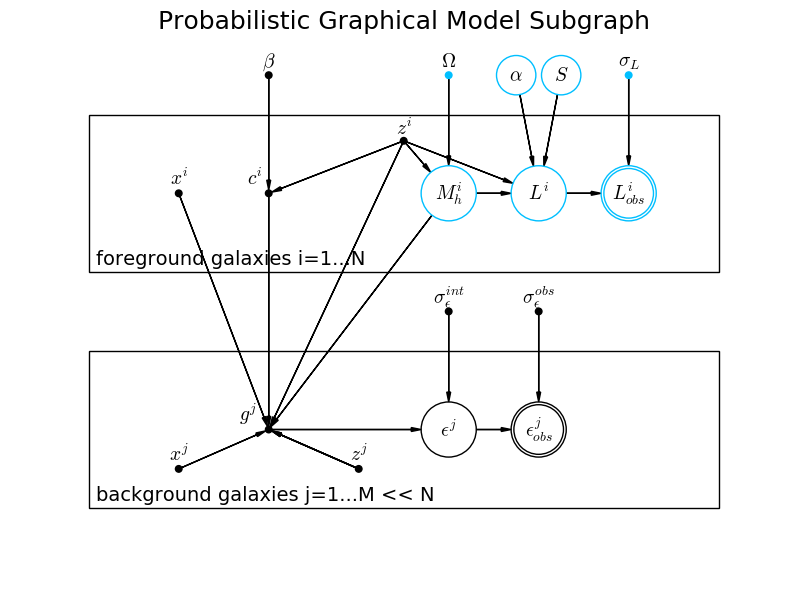

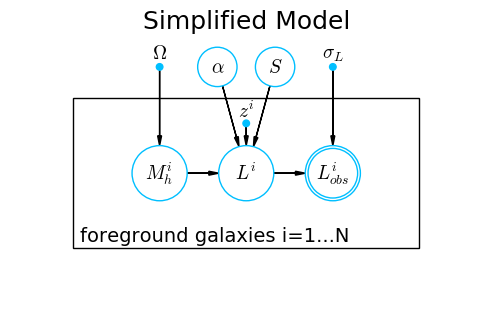

In [30]:
%matplotlib inline

from daft import PGM, Plate, Node
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['font.size'] = 14

#dimensions
pgm_height = 7.
pgm_width = 10.
border = 1.0
scale = 1.4
smallscale=1.0
plate_width = pgm_width - 2. * border
plate_height = (pgm_height - 3. * border) / 2.
plate_1_x = border
plate_1_y = border
plate_2_x = border
plate_2_y = plate_height + 2. * border
plate_1_mid = plate_height / 2. + plate_1_y
plate_2_mid = plate_height / 2. + plate_2_y
seventh = plate_width / 7.

color = '#00bfff'
blue = {'fc': color, 'ec': color}

pgm = PGM([pgm_width, pgm_height], origin=[0, 0], observed_style="inner")

#plate
pgm.add_plate(Plate([plate_1_x, plate_1_y, plate_width, plate_height], label="background galaxies j=1...M << N"))
pgm.add_plate(Plate([plate_2_x, plate_2_y, plate_width, plate_height], label="foreground galaxies i=1...N"))

#nodes
pgm.add_node(Node('x_j', '$x^j$', plate_1_x + seventh, plate_1_mid-border/2., fixed=True))
pgm.add_node(Node('g_j', '$g^j$', plate_1_x + 2. * seventh, plate_1_mid, fixed=True, offset=(-15,0)))
pgm.add_node(Node('z_j', '$z^j$', plate_1_x + 3. * seventh, plate_1_mid-border/2., fixed=True))
pgm.add_node(Node('e_j', '$\epsilon^j$', plate_1_x + 4. * seventh, plate_1_mid, scale=scale))
pgm.add_node(Node('e_obs_j', '$\epsilon_{obs}^j$', plate_1_x + 5. * seventh, plate_1_mid, scale=scale, observed=True))

pgm.add_node(Node('x_i', '$x^i$', plate_2_x + seventh, plate_2_mid, fixed=True))
pgm.add_node(Node('c_i', '$c^i$', plate_2_x + 2. * seventh, plate_2_mid, fixed=True, offset=(-10,0)))
pgm.add_node(Node('z_i', '$z^i$', plate_2_x + 3.5 * seventh, plate_2_mid + plate_height / 3, fixed=True, offset=(0,-2)))
pgm.add_node(Node('M_h_i', '$M_h^i$', plate_2_x + 4. * seventh, plate_2_mid, scale=scale, plot_params=blue))
pgm.add_node(Node('L_i', '$L^i$', plate_2_x + 5. * seventh, plate_2_mid, scale=scale, plot_params=blue))
pgm.add_node(Node('L_obs_i', '$L_{obs}^i$', plate_2_x + 6. * seventh, plate_2_mid, scale=scale, observed=True, plot_params={'ec': color}))

pgm.add_node(Node('e_sig_obs', r'$\sigma_{\epsilon}^{obs}$', plate_1_x + 5. * seventh, pgm_height / 2., fixed=True))
pgm.add_node(Node('e_sig_int', '$\sigma_{\epsilon}^{int}$', plate_1_x + 4. * seventh, pgm_height / 2., fixed=True))

pgm.add_node(Node('beta', r'$\beta$', plate_2_x + 2. * seventh, pgm_height - (border/2.), fixed=True))
pgm.add_node(Node('omega', r'$\Omega$', plate_2_x + 4. * seventh, pgm_height - (border/2.), fixed=True, plot_params=blue))
pgm.add_node(Node('alpha', r'$\alpha$', plate_2_x + 5. * seventh - (seventh/4.), pgm_height - (border/2.), scale=smallscale, plot_params=blue))
pgm.add_node(Node('s', r'$S$', plate_2_x + 5. * seventh + (seventh/4.), pgm_height - (border/2.), scale=smallscale, plot_params=blue))
pgm.add_node(Node('L_sig_int', r'$\sigma_{L}$', plate_2_x + 6. * seventh, pgm_height - (border/2.), fixed=True, plot_params=blue))

# #edges
pgm.add_edge('beta', 'c_i')
pgm.add_edge('omega', 'M_h_i')
pgm.add_edge('M_h_i', 'L_i')
pgm.add_edge('L_i', 'L_obs_i')
pgm.add_edge('alpha', 'L_i')
pgm.add_edge('s', 'L_i')
pgm.add_edge('L_sig_int', 'L_obs_i')
pgm.add_edge('z_i', 'c_i')
pgm.add_edge('z_i', 'M_h_i')
pgm.add_edge('z_i', 'L_i')

pgm.add_edge('x_i', 'g_j')
pgm.add_edge('z_i', 'g_j')
pgm.add_edge('c_i', 'g_j')
pgm.add_edge('M_h_i', 'g_j')

pgm.add_edge('x_j', 'g_j')
pgm.add_edge('z_j', 'g_j')
pgm.add_edge('z_j', 'g_j')
pgm.add_edge('z_j', 'g_j')
pgm.add_edge('g_j', 'e_j')
pgm.add_edge('e_j', 'e_obs_j')
pgm.add_edge('e_sig_int', 'e_j')
pgm.add_edge('e_sig_obs', 'e_obs_j')

pgm.render()
plt.title('Probabilistic Graphical Model Subgraph', fontsize=18)

#dimensions
pgm_height = 3.5
pgm_width = 6.
border = 0.8
scale = 1.4
smallscale=1.0
plate_width = pgm_width - 2. * border
plate_height = (pgm_height - 2. * border)
plate_x = border
plate_y = border
plate_mid = plate_height / 2. + plate_y
fourth = plate_width / 4.

pgm = PGM([pgm_width, pgm_height], origin=[0, 0], observed_style="inner")

#plate
pgm.add_plate(Plate([plate_x, plate_y, plate_width, plate_height], label="foreground galaxies i=1...N"))

pgm.add_node(Node('z_i', '$z^i$', plate_x + 2. * fourth, plate_mid + plate_height / 3.0, fixed=True, plot_params=blue, offset=(0, -2)))
pgm.add_node(Node('M_h_i', '$M_h^i$', plate_x + 1. * fourth, plate_mid, scale=scale, plot_params=blue))
pgm.add_node(Node('L_i', '$L^i$', plate_x + 2. * fourth, plate_mid, scale=scale, plot_params=blue))
pgm.add_node(Node('L_obs_i', '$L_{obs}^i$', plate_x + 3. * fourth, plate_mid, scale=scale, observed=True, plot_params={'ec': color}))
pgm.add_node(Node('omega', r'$\Omega$', plate_x + 1. * fourth, pgm_height - (border/2.), fixed=True, plot_params=blue))
pgm.add_node(Node('alpha', r'$\alpha$', plate_x + 2. * fourth - (fourth/3.), pgm_height - (border/2.), scale=smallscale, plot_params=blue))
pgm.add_node(Node('s', r'$S$', plate_x + 2. * fourth + (fourth/3.), pgm_height - (border/2.), scale=smallscale, plot_params=blue))
pgm.add_node(Node('L_sig_int', r'$\sigma_{L}$', plate_x + 3. * fourth, pgm_height - (border/2.), fixed=True, plot_params=blue))

# #edges
pgm.add_edge('omega', 'M_h_i')
pgm.add_edge('M_h_i', 'L_i')
pgm.add_edge('L_i', 'L_obs_i')
pgm.add_edge('alpha', 'L_i')
pgm.add_edge('s', 'L_i')
pgm.add_edge('L_sig_int', 'L_obs_i')
pgm.add_edge('z_i', 'L_i')
pgm.render()
plt.title('Simplified Model', fontsize=18)

## 3. Distributions

We go through each of the distributions employed in the model. Variables in bold are length N (number of galaxies) vectors, ex. $\textbf{M}_h = (M_{h}^1, M_{h}^2, \dots, M_{h}^N)$. 

Initially, the  prior distribution for $\alpha$ and $S$ will be uniform, making no assumptions. As we gain familiarity with optimal $\alpha$ and $S$ we may change to a normal distribution.

$$P(\alpha, S) \sim \text{Uniform} $$

For the mass prior we use the Press and Schechter formalism in [9] which has the form 

$$P(\textbf{M}_h) \propto \frac{dn}{dM} = f(\sigma)\frac{\rho_m}{M}\frac{dln\sigma^{-1}}{dM}$$

where $\sigma$ is the mass density dispersion and can be computed via $\sigma = \int P(k)\hat{W}(kR)k^2dk$ and the general function f has many alternative implementations [17].  

The conditional luminosity distribution has two components: a lognormal distribution and a functional form which we take from [15] for the mean.

$$ P(\textbf{L} | \alpha, S, \textbf{z}, \textbf{M}_h) \sim \frac{1}{\sqrt{2\pi S^2\textbf{L}^2}}\exp\Big(- \frac{(\ln \textbf{L} - \ln \textbf{u}_L)^2}{2S^2}\Big)$$
$$\ln \textbf{u}_L = \alpha_1 + \alpha_2 \ln(\frac{\textbf{M}_h}{\alpha_3} ) + \alpha_4 \ln (1+\textbf{z})$$

Finally, the conditional observed luminosity is a lognormal distribution 

$$P(\textbf{L}_{obs} | \textbf{L}) \sim \frac{1}{\sqrt{2\pi \sigma_L^2\textbf{L}_{obs}^2}}\exp\Big(- \frac{(\ln \textbf{L}_{obs} - \ln \textbf{L})^2}{2\sigma_L^2}\Big)$$

## 4. Inference

In an inference problem a target posterior distribution is factored into a product of a prior and likelihood. For our model, the factorization is

\begin{align*}
\underbrace{P(\alpha, S | \textbf{L}_{obs}, \textbf{z})}_{posterior} &= \frac{P(\textbf{z})P(\alpha, S)P(\textbf{L}_{obs}|\alpha,S,\textbf{z})}{P(\textbf{L}_{obs}, \textbf{z})} \text{; (Bayes Theorem)}\\
&\propto P(\alpha, S)\Big[P(\textbf{L}_{obs}|\alpha,S,\textbf{z})\Big];\text{ (Normalization)}\\
&\propto \underbrace{P(\alpha, S)}_{prior}\underbrace{\iint P(\textbf{L}_{obs}| \textbf{L})P(\textbf{L}|\alpha, S, \textbf{z}, \textbf{M}_h)P(\textbf{M}_h)d\textbf{M}_hd\textbf{L}}_{likelihood}\\
\end{align*}

The likelihood integrand can be flattened from vectorized form into expanded form $P(\textbf{L}_{obs}| \textbf{L})P(\textbf{L}|\alpha, S, \textbf{z}, \textbf{M}_h)P(\textbf{M}_h) = \prod_{i \in [N]} P(L_{obs}^i| L^i)P(L^i|\alpha, S, z^i, M_h^i)P(M_h^i)$. This huge product can lead to extremely small probabilities and numerical errors, so we compute an intermediate log posterior. After collapsing the likelihood we can exponentiate the posterior to get back to a probability density. 

$$\log P(\alpha, S | \textbf{L}_{obs}, \textbf{z}) = \log P(\alpha,S) + \iint \sum_{i \in [N]} \log(P(L_{obs}^i| L^i)P(L^i|\alpha, S, z^i, M_h^i)P(M_h^i)) d\textbf{M}_hd\textbf{L}$$

# 5. Importance Sampling

To compute the likelihood integral we approximate it with a discretize sum and sample from $P(\textbf{M}_h,\textbf{L}|
\alpha, S)$ with samples weighted by $P(\textbf{L}_{obs}| \textbf{L})$:

\begin{align*}
\mathcal{L} &= \iint P(\textbf{L}_{obs}| \textbf{L})P(\textbf{L}|\alpha, S, \textbf{z}, \textbf{M}_h)P(\textbf{M}_h)d\textbf{M}_hd\textbf{L} \\
&\approx\frac{1}{C} \sum_{\textbf{M}_h \sim P(\textbf{M}_h)} \sum_{\textbf{L} \sim P(\textbf{L}|\alpha, S, \textbf{z}, \textbf{M}_h)} P(\textbf{L}_{obs}| \textbf{L})\\
&= \frac{1}{C}\sum_{(\textbf{M}_h,\textbf{L}) \sim P(\textbf{M}_h,\textbf{L}|
\alpha, S, \textbf{z})}P(\textbf{L}_{obs}| \textbf{L})
\end{align*}

where $C$ is the number of samples. Importance sampling is a general statistics technique for estimating properties of a particular distribution, while only having samples generated from a different distribution than the distribution of interest. The motivation for this is to limit the number of samples needed by using an alternate distribution that yields samples with higher likelihoods or that are easier to compute. In our model this means approximating the likelihood integral with samples from a strategic distribution $Q(\textbf{M}_h,\textbf{L})$, and to reweight the samples in the integral accordingly. 

\begin{align*}
\mathcal{L} &= \iint P(\textbf{L}_{obs}| \textbf{L})P(\textbf{L}|\alpha, S, \textbf{z}, \textbf{M}_h)P(\textbf{M}_h)d\textbf{M}_hd\textbf{L}\\
&= \iint \frac{P(\textbf{L}_{obs}| \textbf{L})P(\textbf{L}|\alpha, S, \textbf{z}, \textbf{M}_h)P(\textbf{M}_h)}{Q(\textbf{M}_h,\textbf{L})}Q(\textbf{M}_h,\textbf{L})d\textbf{M}_hd\textbf{L}\\
&\approx \frac{1}{C} \sum_{(\textbf{M}_h, \textbf{L}) \sim Q(\textbf{M}_{h},\textbf{L})} \frac{P(\textbf{L}_{obs}| \textbf{L})P(\textbf{L}|\alpha, S, \textbf{z}, \textbf{M}_{h})P(\textbf{M}_{h})}{Q(\textbf{M}_{h},\textbf{L})}\\
\end{align*}

In this formulation, samples $Q(\textbf{M}_{h},\textbf{L})$ get weighted by $\frac{P(\textbf{L}_{obs}| \textbf{L})P(\textbf{M}_h, \textbf{L}|\alpha, S, \textbf{z})}{Q(\textbf{M}_{h},\textbf{L})}$. This is an unbiased estimator as long as we ensure we do not divide by a $Q(\textbf{M}_{h},\textbf{L})=0$. The closer we can approximate the numerator's distribution $P(\textbf{L}_{obs}| \textbf{L})P(\textbf{M}_h, \textbf{L}|\alpha, S, \textbf{z})$ with $Q(\textbf{M}_{h},\textbf{L})$, the higher the likelihood of our samples will be. Higher likelihood sampling will lead to faster convegence for the target posterior. Let $\hat{P}$ be a reasonable approximation to the true probability $P$. We achieve a desirable $Q(\textbf{M}_{h}, \textbf{L})$ by factoring $\hat{P}(\textbf{M}_{h}, \textbf{L})$ into products that are 'invertible'.

\begin{align*}
Q(\textbf{M}_{h}, \textbf{L}) &= \hat{P}(\textbf{M}_{h}, \textbf{L})\\
&= \int \hat{P}(\textbf{M}_h | \textbf{L})\hat{P}(\textbf{L}|\textbf{L}_{obs})d\textbf{L}_{obs}\\
&\approx \frac{1}{C}\sum_{\textbf{L}_{obs} \sim P(\textbf{L}_{obs})}\hat{P}(\textbf{M}_h | \textbf{L})\hat{P}(\textbf{L}|\textbf{L}_{obs})\\
\hat{P}(\textbf{M}_h | \textbf{L}) &\sim \text{Delta}\Big[\exp(\alpha_1^\prime)\Big(\frac{\textbf{M}_h}{\alpha_3^\prime}\Big)^{\alpha_2^\prime}(1+z)^{\alpha_4^\prime} \Big]\\
\hat{P}(\textbf{L}|\textbf{L}_{obs}) &\sim \frac{1}{\sqrt{2\pi \sigma_L^2\textbf{L}^2}}\exp\Big(- \frac{(\ln \textbf{L} - \ln \textbf{L}_{obs})^2}{2\sigma_L^2}\Big)\\\\
\end{align*}

The two conditional distributions are approximate inverses of the reverse conditioned distribution that we use above. We use the distribution of the data $P(\textbf{L}_{obs})$ to draw the samples.

##### Validating Q 

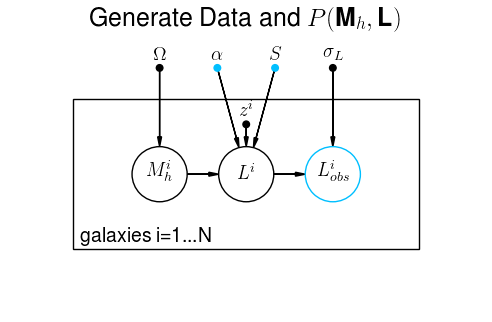

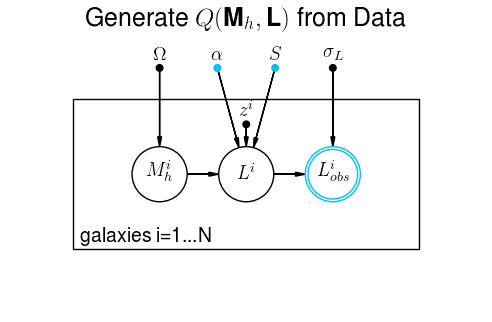

In [32]:
from matplotlib import rc
rc("text", usetex=True)

#dimensions
pgm_height = 3.5
pgm_width = 6.
border = 0.8
scale = 1.4
smallscale=1.0
plate_width = pgm_width - 2. * border
plate_height = (pgm_height - 2. * border)
plate_x = border
plate_y = border
plate_mid = plate_height / 2. + plate_y
fourth = plate_width / 4.

color = '#00bfff'
blue = {'fc': color, 'ec': color}

pgm = PGM([pgm_width, pgm_height], origin=[0, 0], observed_style="inner")

#plate
pgm.add_plate(Plate([plate_x, plate_y, plate_width, plate_height], label="galaxies i=1...N"))

pgm.add_node(Node('z_i', '$z^i$', plate_x + 2. * fourth, plate_mid + plate_height / 3.0, fixed=True))
pgm.add_node(Node('M_h_i', '$M_h^i$', plate_x + 1. * fourth, plate_mid, scale=scale))
pgm.add_node(Node('L_i', '$L^i$', plate_x + 2. * fourth, plate_mid, scale=scale))
pgm.add_node(Node('L_obs_i', '$L_{obs}^i$', plate_x + 3. * fourth, plate_mid, scale=scale, plot_params=blue))
pgm.add_node(Node('omega', r'$\Omega$', plate_x + 1. * fourth, pgm_height - (border/2.), fixed=True))
pgm.add_node(Node('alpha', r'$\alpha$', plate_x + 2. * fourth - (fourth/3.), pgm_height - (border/2.), scale=smallscale, plot_params=blue, fixed=True))
pgm.add_node(Node('s', r'$S$', plate_x + 2. * fourth + (fourth/3.), pgm_height - (border/2.), scale=smallscale, plot_params=blue, fixed=True))
pgm.add_node(Node('L_sig_int', r'$\sigma_{L}$', plate_x + 3. * fourth, pgm_height - (border/2.), fixed=True))

# #edges
pgm.add_edge('omega', 'M_h_i')
pgm.add_edge('M_h_i', 'L_i')
pgm.add_edge('L_i', 'L_obs_i')
pgm.add_edge('alpha', 'L_i')
pgm.add_edge('s', 'L_i')
pgm.add_edge('L_sig_int', 'L_obs_i')
pgm.add_edge('z_i', 'L_i')
pgm.render()
plt.title(r'Generate Data and $P(\textbf{M}_h,\textbf{L})$', fontsize=18)

#dimensions
pgm_height = 3.5
pgm_width = 6.
border = 0.8
scale = 1.4
smallscale=1.0
plate_width = pgm_width - 2. * border
plate_height = (pgm_height - 2. * border)
plate_x = border
plate_y = border
plate_mid = plate_height / 2. + plate_y
fourth = plate_width / 4.

color = '#00bfff'
blue = {'fc': color, 'ec': color}

pgm = PGM([pgm_width, pgm_height], origin=[0, 0], observed_style="inner")

#plate
pgm.add_plate(Plate([plate_x, plate_y, plate_width, plate_height], label="galaxies i=1...N"))

pgm.add_node(Node('z_i', '$z^i$', plate_x + 2. * fourth, plate_mid + plate_height / 3.0, fixed=True))
pgm.add_node(Node('M_h_i', '$M_h^i$', plate_x + 1. * fourth, plate_mid, scale=scale))
pgm.add_node(Node('L_i', '$L^i$', plate_x + 2. * fourth, plate_mid, scale=scale))
pgm.add_node(Node('L_obs_i', '$L_{obs}^i$', plate_x + 3. * fourth, plate_mid, scale=scale, plot_params={'ec': color}, observed=True))
pgm.add_node(Node('omega', r'$\Omega$', plate_x + 1. * fourth, pgm_height - (border/2.), fixed=True))
pgm.add_node(Node('alpha', r'$\alpha$', plate_x + 2. * fourth - (fourth/3.), pgm_height - (border/2.), scale=smallscale, plot_params=blue, fixed=True))
pgm.add_node(Node('s', r'$S$', plate_x + 2. * fourth + (fourth/3.), pgm_height - (border/2.), scale=smallscale, plot_params=blue, fixed=True))
pgm.add_node(Node('L_sig_int', r'$\sigma_{L}$', plate_x + 3. * fourth, pgm_height - (border/2.), fixed=True))

# #edges
pgm.add_edge('omega', 'M_h_i')
pgm.add_edge('M_h_i', 'L_i')
pgm.add_edge('L_i', 'L_obs_i')
pgm.add_edge('alpha', 'L_i')
pgm.add_edge('s', 'L_i')
pgm.add_edge('L_sig_int', 'L_obs_i')
pgm.add_edge('z_i', 'L_i')
pgm.render()
plt.title(r'Generate $Q(\textbf{M}_h,\textbf{L})$ from Data', fontsize=18)

To validate Q first we fix $\alpha, S$ to a fit from the eight SDSS release [15].

\begin{align*}
\alpha_1 &= 10.709 \log L_{\odot}h^{-2}\\
\alpha_2 &= 0.359 \\
\alpha_3 &= 2.35 \times 10^{14} M_{\odot}\\
\alpha_4 &= 1.10\\
S &= 0.155 \log L_{\odot}h^{-2}\\
\end{align*}

Then we use galaxies from the Millennium Simulation [2] to generate mock observed luminosities and the $(\textbf{M}_h, \textbf{L})$ samples which allow us to build the $P(\textbf{M}_h, \textbf{L})$ joint distribution. The first PGM above summarizes our assumptions and distributions in this process. Next, we use the mock observed luminosities and $\hat{P}$ inversions to make $(\textbf{M}_h, \textbf{L})$ samples which allow us to build the $Q(\textbf{M}_h, \textbf{L})$ joint distribution. We compare the first 500 samples from these distributions below and confirm that $Q$ is a good approximation to $P$.

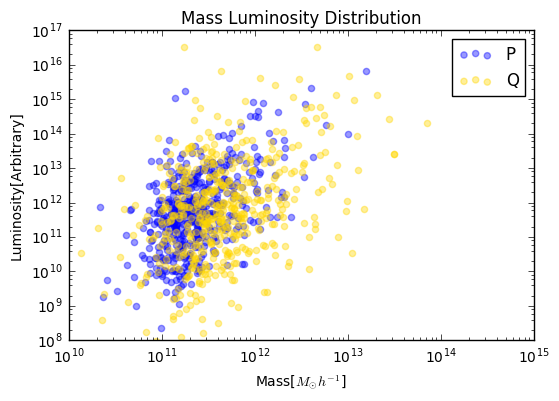

In [35]:
from IPython.display import Image
Image(filename='QvsP.png') 

## 6. Dataset 

Our desire to eventually incorporate weak lensing and mass mapping elements into our statistical model has directed our choice to use the Millennium Simulation for the redshift and angular location of galaxies [2]. There is also a companion kappamap and shearmap from [7] which will allow us to compute a likelihood for weak lensing. The halo masses from the simulated catalog can be used to validate the mass mapping of our eventual model.

Below we plot the mass structure of the field in views of declination, right ascension, and redshift.

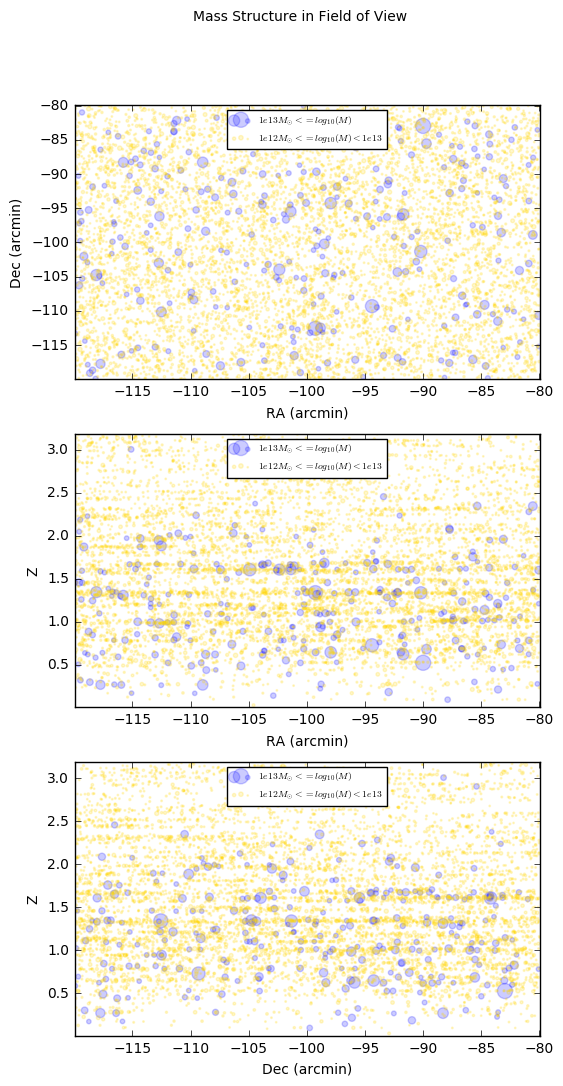

In [38]:
Image('mass_struct.png')

## 7. Next Steps
- Create database table with a schema containing columns: gal_id, alpha_1, alpha_2, alpha_3, alpha_4, S, L, M_h, log_Q_L, log_Q_M, log_P_obs, log_P_L, log_P_M.
- Generate inference samples.
- Collapse likelihood integral and produce target posteroir.

## References
[1] A. Vale and J.P. Ostriker. Linking halo mass to galaxy luminosity. https://arxiv.org/pdf/astro-ph/0402500v2.pdf. 2004.

[2] V. Springel, S. D. M. White, A. Jenkins, C. S. Frenk, N. Yoshida, L. Gao, J. Navarro, R. Thacker, D. Croton, J. Helly, J. A. Peacock, S. Cole, P. Thomas, H. Couchman, A. Evrard, J. Colberg, and F. Pearce. Simulations of the formation, evolution and clustering of galaxies and quasars. http://www.nature.com/nature/journal/v435/n7042/full/nature03597.html. 2005.

[3] Julio F. Navarro, Carlos S. Frenk, Simon D.M. White. The Structure of Cold Dark Matter Halos. https://arxiv.org/pdf/astro-ph/9508025v1.pdf. 1995.

[4] Edward A. Baltz1, Phil Marshall1, Masamune Oguri1. Analytic models of plausible gravitational lens. https://arxiv.org/pdf/0705.0682v3.pdf. 2007.

[5] Paul Schechter. An Analytic Expression For The Luminosity Function of Galaxies. http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1976ApJ...203..297S&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf. 1975.

[6] Phil Marshall. Physical component analysis of galaxy cluster weak gravitational lensing data. https://arxiv.org/pdf/astro-ph/0511287v2.pdf. 2004.

[7] S. Hilbert, J. Hartlap, S.D.M. White1, and P. Schneider. Ray-tracing through the Millennium Simulation: Born corrections and lens-lens coupling in cosmic shear and galaxy-galaxy lensing. https://arxiv.org/pdf/0809.5035v2.pdf. 2009.

[8] Thomas E. Collett, Philip J. Marshall, Matthew W. Auger, Stefan Hilbert, Sherry H. Suyu, Zachary Greene, Tommaso Treu, Christopher D. Fassnacht, Leon V. E. Koopmans, Marusa Brada, Roger D. Blandford. Reconstructing the Lensing Mass in the Universe from Photometric Catalogue Data. https://arxiv.org/pdf/1303.6564v1.pdf. 2013.

[9] William Press, Paul Schechter. Formation of Galaxies and Clusters of Galaxies by Self-Similar Gravitational Condensation. http://adsabs.harvard.edu/abs/1974ApJ...187..425P. 1974. 

[10] A. Jenkins, C.S. Frenk, S.D.M. White, J.M. Colberg, S. Cole, A.E. Evrard, H.M.P. Couchman, N. Yoshida. The mass function of dark matter halos. http://adsabs.harvard.edu/abs/2001MNRAS.321..372J. 2001.

[11] Ravi Sheth, Giuseppe Tormen. An excursion set model of hierarchical clustering: ellipsoidal collapse and the moving barrier. http://adsabs.harvard.edu/abs/2002MNRAS.329...61S. 2002.

[12] Michael Warren, Kevork Abazajian, Daniel Holz, Luis Teodoro. Precision Determination of the Mass Function of Dark Matter Halos. http://adsabs.harvard.edu/abs/2006ApJ...646..881W. 2006.

[13] Jeremy Tinker, Andrey Kravtsov, Anatoly Klypin, Kevork Abazajian, Michael Warren, Gustavo Yepes, Stefan Gottlober, Daniel Holz. Toward a Halo Mass Function for Precision Cosmology: The Limits of Universality. http://adsabs.harvard.edu/abs/2008ApJ...688..709T. 2008.

[14] Matthew Turk, Britton Smith, Jeffrey Oishi, Stephen Skory, Samuel Skillman, Tom Abell, Michael Norman. yt: A Multi-code Analysis Toolkit for Astrophysical Simulation Data. http://adsabs.harvard.edu/abs/2011ApJS..192....9T. 2011.

[15] Rachel Marie Reddick. ReddiCosmology and galaxy formation using the galaxy-halo connection to probe cosmology. https://searchworks.stanford.edu/view/10531737. 2014.

[16] D. N. Spergel, L. Verde, H. V. Peiris, E. Komatsu, M. R. Nolta, C. L. Bennett, M. Halpern, G. Hinshaw, N. Jarosik, A. Kogut, M. Limon, S. S. Meyer, L. Page, G. S. Tucker, J. L. Weiland, E. Wollack, and E. L. Wright. First-Year Wilkinson Microwave Anisotropy Probe (WMAP) Observations: Determination of Cosmological Parameters. https://arxiv.org/abs/astro-ph/0302209. 2003.

[17] Steven Murray, Chris Power, Aaron Robotham
. HMFcalc: An Online Tool for Calculating Dark Matter Halo Mass Functions. https://arxiv.org/abs/1306.6721. 2013.